In [1]:
!pip install tensorflow-plot
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

  Stored in directory: /root/.cache/pip/wheels/39/07/7e/0a568d2f3ee877bc2f09281042ab659a8bde5fd66081a2689d
  Stored in directory: /root/.cache/pip/wheels/e5/d9/4a/0c3162411bad4df21befe385cea5bb26458ebb1aa9b2e1c13e
Successfully built tensorflow-plot biwrap
--2019-04-30 21:00:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.22.236.254, 52.3.53.115, 34.226.180.131, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.22.236.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.30M  38.1MB/s    in 0.4s    

2019-04-30 21:00:01 (38.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [4]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://98703488.ngrok.io


In [5]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras import applications
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math

import os
from shutil import move


Using TensorFlow backend.


In [6]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz

!rm -rf train
!rm -rf validation
# create base folders
os.mkdir('train')
os.mkdir('validation')

######################################################################## 100.0%


In [7]:
root = '101_ObjectCategories'
# exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
# train_split, val_split = 0.7, 0.15
# 
categories = [x[0] for x in os.walk(root) if x[0]][1:]
# categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]
# categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]
for category in categories:
  label= category.split('/')[1];
  os.mkdir('./train'+os.sep+label)
  os.mkdir('./validation'+os.sep+label)

print(categories)

['101_ObjectCategories/stop_sign', '101_ObjectCategories/gramophone', '101_ObjectCategories/BACKGROUND_Google', '101_ObjectCategories/ceiling_fan', '101_ObjectCategories/watch', '101_ObjectCategories/helicopter', '101_ObjectCategories/scorpion', '101_ObjectCategories/scissors', '101_ObjectCategories/Faces', '101_ObjectCategories/water_lilly', '101_ObjectCategories/sunflower', '101_ObjectCategories/car_side', '101_ObjectCategories/rooster', '101_ObjectCategories/mandolin', '101_ObjectCategories/trilobite', '101_ObjectCategories/brain', '101_ObjectCategories/crocodile', '101_ObjectCategories/sea_horse', '101_ObjectCategories/ibis', '101_ObjectCategories/Leopards', '101_ObjectCategories/accordion', '101_ObjectCategories/camera', '101_ObjectCategories/grand_piano', '101_ObjectCategories/Motorbikes', '101_ObjectCategories/chair', '101_ObjectCategories/umbrella', '101_ObjectCategories/joshua_tree', '101_ObjectCategories/gerenuk', '101_ObjectCategories/binocular', '101_ObjectCategories/pagoda

In [0]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    counter=0
    validatin_ratio=0.2
    for img_path in images:
      counter+=1
      dest='train'
      if counter>(1-validatin_ratio)*len(images): dest='validation'
      spl=img_path.split('/');
      move(img_path,dest+os.sep+spl[1]+os.sep+spl[2])

# count the number of classes
num_classes = len(categories)

In [0]:
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'train'
validation_data_dir = 'validation'

# number of epochs to train top model
epochs = 30
# batch size used by flow_from_directory and predict_generator
batch_size = 128

In [0]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
#     model = applications.ResNet50(include_top=False, weights='imagenet')
    
    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    print(len(generator.filenames))
    print(generator.class_indices)
    print(len(generator.class_indices))

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(
        generator, predict_size_train)

    np.save('bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        generator, predict_size_validation)

    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)
    print(predict_size_validation)
    print(predict_size_train)

==================================================

In [0]:
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)

In [0]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt    
import itertools
import tensorflow as tf

import pandas as pd
import seaborn as sns



class ConfusionMatrixPlotter(Callback):
    """Plot the confusion matrix on a graph and update after each epoch
    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
        normalize: True - normalize to [0,1], False - keep as is
        cmap: Specify matplotlib colour map
        title: Graph Title
    """
    def __init__(self, X_val, Y_val, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix'):
        self.X_val = X_val
        self.Y_val = Y_val
        self.title = title
        self.classes = classes
        self.normalize = normalize
        self.cmap = cmap
        plt.ion()
        #plt.show()
        plt.figure(figsize=(10,10))

        plt.title(self.title)
        
        

    def on_train_begin(self, logs={}):
        pass
      
    def cm_analysis(self, y_true, y_pred, labels, ymap=None, figsize=(10,10)):
        """
        Generate matrix plot of confusion matrix with pretty annotations.
        The plot image is saved to disk.
        args: 
          y_true:    true label of the data, with shape (nsamples,)
          y_pred:    prediction of the data, with shape (nsamples,)
          filename:  filename of figure file to save
          labels:    string array, name the order of class labels in the confusion matrix.
                     use `clf.classes_` if using scikit-learn models.
                     with shape (nclass,).
          ymap:      dict: any -> string, length == nclass.
                     if not None, map the labels & ys to more understandable strings.
                     Caution: original y_true, y_pred and labels must align.
          figsize:   the size of the figure plotted.
        """
        if ymap is not None:
            y_pred = [ymap[yi] for yi in y_pred]
            y_true = [ymap[yi] for yi in y_true]
            labels = [ymap[yi] for yi in labels]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        cm_perc = cm / cm_sum.astype(float) * 100
        annot = np.empty_like(cm).astype(str)
        nrows, ncols = cm.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cm[i, j]
                p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%.1f%%\n%d' % (p, c)
        cm = pd.DataFrame(cm, index=labels, columns=labels)
        cm.index.name = 'Actual'
        cm.columns.name = 'Predicted'
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(cm, annot=annot, fmt='', ax=ax)
#         plt.savefig(filename)
    
    def on_epoch_end(self, epoch, logs={}): 
      
        plt.clf()
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = np.argmax(self.Y_val, axis=1)

        sess = tf.Session()
        img_d_summary_dir = os.path.join("/log", "summaries", "img")
        img_d_summary_writer = tf.summary.FileWriter(img_d_summary_dir,sess.graph)
        img_d_summary = plot_confusion_matrix(max_y, max_pred, self.classes, tensor_name='dev/cm')
        img_d_summary_writer.add_summary(img_d_summary, epoch)
        
# #         self.cm_analysis(self.Y_val,max_y,"test")
#         cnf_mat = confusion_matrix(max_y, max_pred)
   
#         if self.normalize:
#             cnf_mat = cnf_mat.astype('float') / cnf_mat.sum(axis=1)[:, np.newaxis]

#         thresh = cnf_mat.max() / 2.
#         for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
#             plt.text(j, i, cnf_mat[i, j],                                          
#                          horizontalalignment="center",
#                          color="white" if cnf_mat[i, j] > thresh else "black")

#         plt.imshow(cnf_mat, interpolation='nearest', cmap=self.cmap)

#         # Labels
#         tick_marks = np.arange(len(self.classes))
#         plt.xticks(tick_marks, self.classes, rotation=45)
#         plt.yticks(tick_marks, self.classes)

#         plt.colorbar()
                                                                                                         
#         plt.tight_layout()                                                    
#         plt.ylabel('True label')                                              
#         plt.xlabel('Predicted label')                                         
#         #plt.draw()
#         plt.show()
#         plt.pause(0.001)
        

In [0]:
from textwrap import wrap
import re
import itertools
import tfplot
import matplotlib
import numpy as np
from sklearn.metrics import confusion_matrix



def plot_confusion_matrix(correct_labels, predict_labels, labels, title='Confusion matrix', tensor_name = 'MyFigure/image', normalize=False):
  ''' 
  Parameters:
      correct_labels                  : These are your true classification categories.
      predict_labels                  : These are you predicted classification categories
      labels                          : This is a lit of labels which will be used to display the axix labels
      title='Confusion matrix'        : Title for your matrix
      tensor_name = 'MyFigure/image'  : Name for the output summay tensor

  Returns:
      summary: TensorFlow summary 

  Other itema to note:
      - Depending on the number of category and the data , you may have to modify the figzie, font sizes etc. 
      - Currently, some of the ticks dont line up due to rotations.
  '''
  cm = confusion_matrix(correct_labels, predict_labels, labels=labels)
  if normalize:
      cm = cm.astype('float')*10 / cm.sum(axis=1)[:, np.newaxis]
      cm = np.nan_to_num(cm, copy=True)
      cm = cm.astype('int')

  np.set_printoptions(precision=2)
  ###fig, ax = matplotlib.figure.Figure()

  fig = matplotlib.figure.Figure(figsize=(7, 7), dpi=320, facecolor='w', edgecolor='k')
  ax = fig.add_subplot(1, 1, 1)
  im = ax.imshow(cm, cmap='Oranges')

  classes = [re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', x) for x in labels]
  classes = ['\n'.join(wrap(l, 40)) for l in classes]

  tick_marks = np.arange(len(classes))

  ax.set_xlabel('Predicted', fontsize=7)
  ax.set_xticks(tick_marks)
  c = ax.set_xticklabels(classes, fontsize=4, rotation=-90,  ha='center')
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  ax.set_ylabel('True Label', fontsize=7)
  ax.set_yticks(tick_marks)
  ax.set_yticklabels(classes, fontsize=4, va ='center')
  ax.yaxis.set_label_position('left')
  ax.yaxis.tick_left()

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      ax.text(j, i, format(cm[i, j], 'd') if cm[i,j]!=0 else '.', horizontalalignment="center", fontsize=6, verticalalignment='center', color= "black")
  fig.set_tight_layout(True)
  summary = tfplot.figure.to_summary(fig, tag=tensor_name)
  return summary

==================================================

In [0]:
def train_top_model():
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to user later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('bottleneck_features_validation.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.75))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
#     plotter = ConfusionMatrixPlotter(X_val=validation_data, classes=generator_top.classes, Y_val=validation_labels)

    

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels),callbacks=[tbCallBack])

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [15]:
save_bottlebeck_features()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 5s 0us/step
Found 7280 images belonging to 102 classes.
7280
{'BACKGROUND_Google': 0, 'Faces': 1, 'Faces_easy': 2, 'Leopards': 3, 'Motorbikes': 4, 'accordion': 5, 'airplanes': 6, 'anchor': 7, 'ant': 8, 'barrel': 9, 'bass': 10, 'beaver': 11, 'binocular': 12, 'bonsai': 13, 'brain': 14, 'brontosaurus': 15, 'buddha': 16, 'butterfly': 17, 'camera': 18, 'cannon': 19, 'car_side': 20, 'ceiling_fan': 21, 'cellphone': 22, 'chair': 23, 'chandelier': 24, 'cougar_body': 25, 'cougar_face': 26, 'crab': 27, 'crayfish': 28, 'crocodile': 29, 'crocodile_head': 30, 'cup': 31, 'dalmatian': 32, 'dollar_bill': 33, 'dolphin': 34, 'dragonfly': 35, 'electric_guitar': 36, 'elephant': 37, 'emu': 38, 'euphonium': 39, 'ewer': 40, 'ferry': 41, 'flamingo': 42, 'flamingo_head': 43, 'garfield': 44, 'gerenuk': 45, 'gramophone': 46, 'grand_piano': 47, 'hawksbill': 48, 'headphone': 49, 'hedgehog': 5

In [0]:
!rm -rf log

Found 7280 images belonging to 102 classes.
Found 1864 images belonging to 102 classes.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 7280 samples, validate on 1864 samples
Epoch 1/30
7280/7280 [==============================] - 3s 367us/step - loss: 4.7002 - acc: 0.3089 - val_loss: 2.3786 - val_acc: 0.5166
Epoch 2/30
7280/7280 [==============================] - 2s 246us/step - loss: 2.4057 - acc: 0.4587 - val_loss: 1.6598 - val_acc: 0.6508
Epoch 3/30
7280/7280 [==============================] - 2s 243us/step - loss: 1.9491 - acc: 0.5352 - val_loss: 1.3135 - val_acc: 0.7221
Epoch 4/30
7280/7280 [==============================] - 2s 249us/step - loss: 1.6278 - acc: 0.5960 - val_loss: 1.0987 - val_acc: 0.7344
Epoch 5/30
7280/7280 [==============================] - 2s 252us/step - loss: 1.4648 - acc: 0.6210 - val_loss: 0.9185 - val_acc: 0.7833
Epoch 6/30
7280/7280 

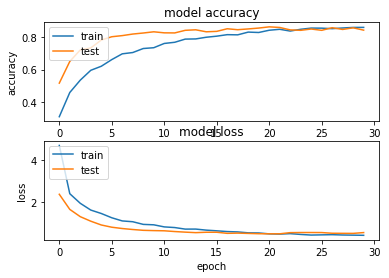

In [17]:
train_top_model()